# EE 467 Lab 2: Breaking CAPTCHAs with PyTorch

This notebook is a PyTorch re-implementation of the TensorFlow/Keras CNN pipeline from the lab.

It:
- Extracts CAPTCHA images
- Segments each CAPTCHA into 4 character crops
- Trains a CNN to classify characters
- Reconstructs full CAPTCHA strings and reports end-to-end accuracy

**Notes:**
- Uses the same register-free, pure software pipeline as the TensorFlow version.
- Training uses GPU automatically if available.

In [1]:
# Install dependencies (run once)
%pip -q install matplotlib scikit-learn "opencv-python>4" imutils torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, glob, math, pickle
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split

from lab_2_helpers import resize_to_fit, print_images, group_every


## Unpack dataset

In [3]:
# Extract provided images (creates ./captcha-images)
!tar -xJf captcha-images.tar.xz

In [4]:
CAPTCHA_IMAGE_FOLDER = "./captcha-images"
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_paths.sort()
print("Found images:", len(captcha_image_paths))
pprint(captcha_image_paths[:10])

Found images: 1136
['./captcha-images\\2A2X.png',
 './captcha-images\\2A5R.png',
 './captcha-images\\2A5Z.png',
 './captcha-images\\2A98.png',
 './captcha-images\\2A9N.png',
 './captcha-images\\2AD9.png',
 './captcha-images\\2AEF.png',
 './captcha-images\\2APC.png',
 './captcha-images\\2AQ7.png',
 './captcha-images\\2AX2.png']


In [5]:
def extract_captcha_text(image_path: str) -> str:
    """Extract the correct CAPTCHA text from an image file name."""
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(p) for p in captcha_image_paths]
pprint(captcha_texts[:10])

['2A2X', '2A5R', '2A5Z', '2A98', '2A9N', '2AD9', '2AEF', '2APC', '2AQ7', '2AX2']


## Load and preprocess CAPTCHA images
We convert to grayscale and add padding to help contour detection.

Figure(2000x500)


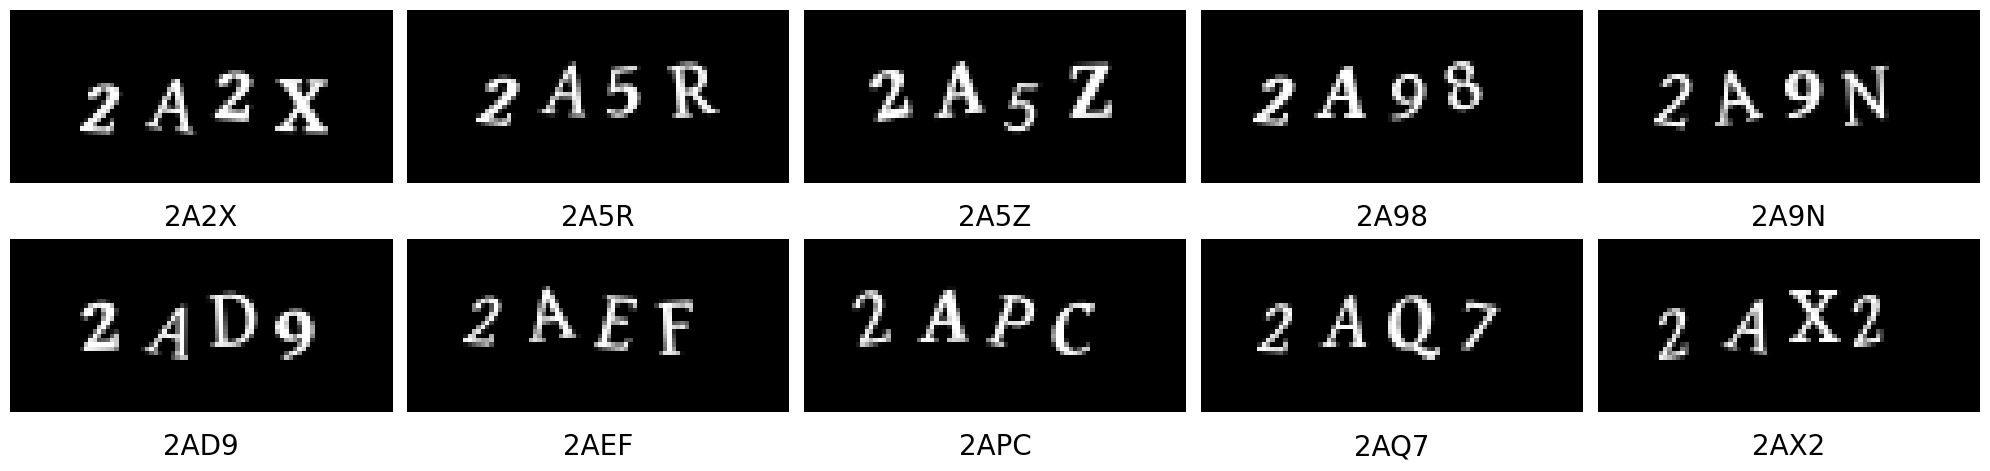

In [6]:
def load_transform_image(image_path: str) -> np.ndarray:
    """Load a CAPTCHA, convert to grayscale, and pad the border."""
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_padded = cv2.copyMakeBorder(
        image_gray, 8, 8, 8, 8, borderType=cv2.BORDER_REPLICATE
    )
    return image_padded

captcha_images = [load_transform_image(p) for p in captcha_image_paths]

print_images(
    captcha_images[:10],
    n_rows=2,
    texts=captcha_texts[:10]
)

## Train / test split

In [7]:
TVT_SPLIT_SEED = 31528476

captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Character segmentation (bounding boxes)
We threshold, find contours, then split wide contours that likely contain two merged characters.

In [8]:
def extract_chars(image: np.ndarray):
    """Return a list of 4 character crops (left-to-right) or None if extraction fails."""
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions) != 4:
        return None

    char_regions.sort(key=lambda r: r[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)

    return char_images

## Build a character-level dataset
We create (20×20) grayscale character images and labels, then split into train/validation.

In [9]:
def make_feature(char_image: np.ndarray) -> np.ndarray:
    """Resize to 20x20 and add a channel dimension (H,W,1)."""
    image_resized = resize_to_fit(char_image, 20, 20)
    feature = image_resized[..., None]
    return feature

# Build character samples from the train/validation CAPTCHAs
char_features = []
char_labels = []

extract_fail_tv = 0
for captcha_img, captcha_txt in zip(captcha_images_tv, captcha_texts_tv):
    chars = extract_chars(captcha_img)
    if chars is None:
        extract_fail_tv += 1
        continue
    for char_img, ch in zip(chars, captcha_txt):
        char_features.append(make_feature(char_img))
        char_labels.append(ch)

print("Character samples:", len(char_labels))
print("Failed CAPTCHA segmentations (train/val):", extract_fail_tv)

# Map labels to indices
classes = sorted(list(set(char_labels)))
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

y = np.array([class_to_idx[c] for c in char_labels], dtype=np.int64)
X = np.array(char_features, dtype=np.float32) / 255.0  # [0,1], shape (N,20,20,1)

print("Num classes:", len(classes))
print("X shape:", X.shape, "y shape:", y.shape)

# Save label mapping (optional, similar to TF version)
LABELS_PATH = "./labels_pytorch.pkl"
with open(LABELS_PATH, "wb") as f:
    pickle.dump({"classes": classes, "class_to_idx": class_to_idx, "idx_to_class": idx_to_class}, f)

Character samples: 3580
Failed CAPTCHA segmentations (train/val): 13
Num classes: 32
X shape: (3580, 20, 20, 1) y shape: (3580,)


In [10]:
class CaptchaCharDataset(Dataset):
    """Character dataset: returns (1,20,20) float tensor and class index."""
    def __init__(self, X_np: np.ndarray, y_np: np.ndarray):
        self.X = X_np
        self.y = y_np

    def __len__(self):
        return int(self.y.shape[0])

    def __getitem__(self, idx):
        x = self.X[idx]                 # (20,20,1)
        x = np.transpose(x, (2,0,1))    # -> (1,20,20)
        x_t = torch.from_numpy(x).float()
        y_t = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x_t, y_t

dataset = CaptchaCharDataset(X, y)

# Train/validation split (75/25 like TF notebook)
val_frac = 0.25
n_total = len(dataset)
n_val = int(n_total * val_frac)
n_train = n_total - n_val

g = torch.Generator().manual_seed(955996)
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=g)

print("Train chars:", len(train_ds))
print("Val chars:", len(val_ds))

Train chars: 2685
Val chars: 895


## CNN model (PyTorch)
Architecture matches the Keras model:
- Conv(20, 5×5, same) + ReLU + MaxPool
- Conv(50, 5×5, same) + ReLU + MaxPool
- FC(500) + ReLU
- FC(num_classes)

In [11]:
class CaptchaCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(20, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(50 * 5 * 5, 500),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = CaptchaCNN(n_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

BATCH_SIZE = 32
N_EPOCHS = 10

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

MODEL_PATH = "./captcha_cnn_pytorch.pt"


Device: cpu


In [12]:
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        train_acc += (torch.argmax(logits, dim=1) == yb).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            val_acc += (torch.argmax(logits, dim=1) == yb).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d}/{N_EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

# Save model weights
torch.save({
    "model_state_dict": model.state_dict(),
    "classes": classes,
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
}, MODEL_PATH)

print("Saved:", MODEL_PATH)

Epoch 01/10 | train loss 2.1944 acc 0.4089 | val loss 0.6234 acc 0.8223
Epoch 02/10 | train loss 0.2413 acc 0.9434 | val loss 0.1651 acc 0.9777
Epoch 03/10 | train loss 0.0891 acc 0.9814 | val loss 0.1277 acc 0.9877
Epoch 04/10 | train loss 0.0469 acc 0.9926 | val loss 0.1134 acc 0.9855
Epoch 05/10 | train loss 0.0263 acc 0.9940 | val loss 0.1067 acc 0.9888
Epoch 06/10 | train loss 0.0173 acc 0.9959 | val loss 0.1453 acc 0.9687
Epoch 07/10 | train loss 0.0082 acc 0.9985 | val loss 0.1019 acc 0.9899
Epoch 08/10 | train loss 0.0043 acc 0.9993 | val loss 0.1036 acc 0.9899
Epoch 09/10 | train loss 0.0016 acc 1.0000 | val loss 0.1077 acc 0.9899
Epoch 10/10 | train loss 0.0013 acc 1.0000 | val loss 0.1110 acc 0.9899
Saved: ./captcha_cnn_pytorch.pt


## End-to-end evaluation on test CAPTCHAs
We segment each test CAPTCHA into 4 characters, classify each character, then concatenate into the predicted text.

In [13]:
# Load mapping + model (in case you restart the kernel)
ckpt = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

classes = ckpt["classes"]
idx_to_class = ckpt["idx_to_class"]

def predict_char_batch(char_images):
    """Predict class indices for a list of raw char crops."""
    feats = [make_feature(img) for img in char_images]          # (20,20,1)
    feats = np.array(feats, dtype=np.float32) / 255.0
    feats = np.transpose(feats, (0,3,1,2))                      # (N,1,20,20)
    xb = torch.from_numpy(feats).float().to(device)
    with torch.no_grad():
        logits = model(xb)
        pred_idx = torch.argmax(logits, dim=1).cpu().numpy()
    return pred_idx

# Predict each CAPTCHA
pred_texts = []
extract_failed_indices = []

DUMMY_CHAR = np.zeros((20,20), dtype=np.uint8)

for i, captcha_img in enumerate(captcha_images_test):
    chars = extract_chars(captcha_img)
    if chars is None:
        extract_failed_indices.append(i)
        # If extraction fails, predict "????"
        pred_texts.append("????")
        continue

    pred_idx = predict_char_batch(chars)
    pred_chars = [idx_to_class[int(j)] for j in pred_idx]
    pred_texts.append("".join(pred_chars))

print("Failed CAPTCHA segmentations (test):", len(extract_failed_indices))

Failed CAPTCHA segmentations (test): 6


In [14]:
# Compute accuracy
n_test = len(captcha_texts_test)
n_correct = sum(int(p == a) for p, a in zip(pred_texts, captcha_texts_test))
acc = n_correct / n_test

print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", acc)

# of test CAPTCHAs: 228
# correctly recognized: 214
Accuracy: 0.9385964912280702


Figure(2000x500)
Figure(2000x600)


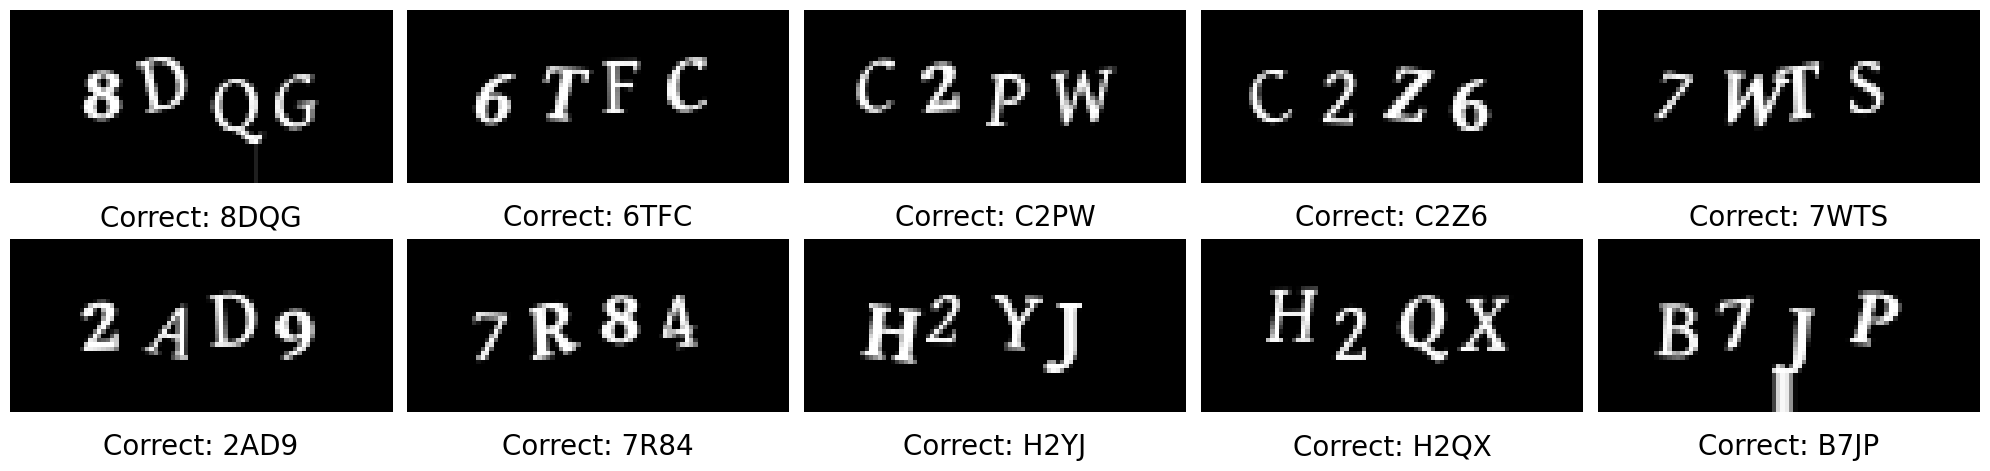

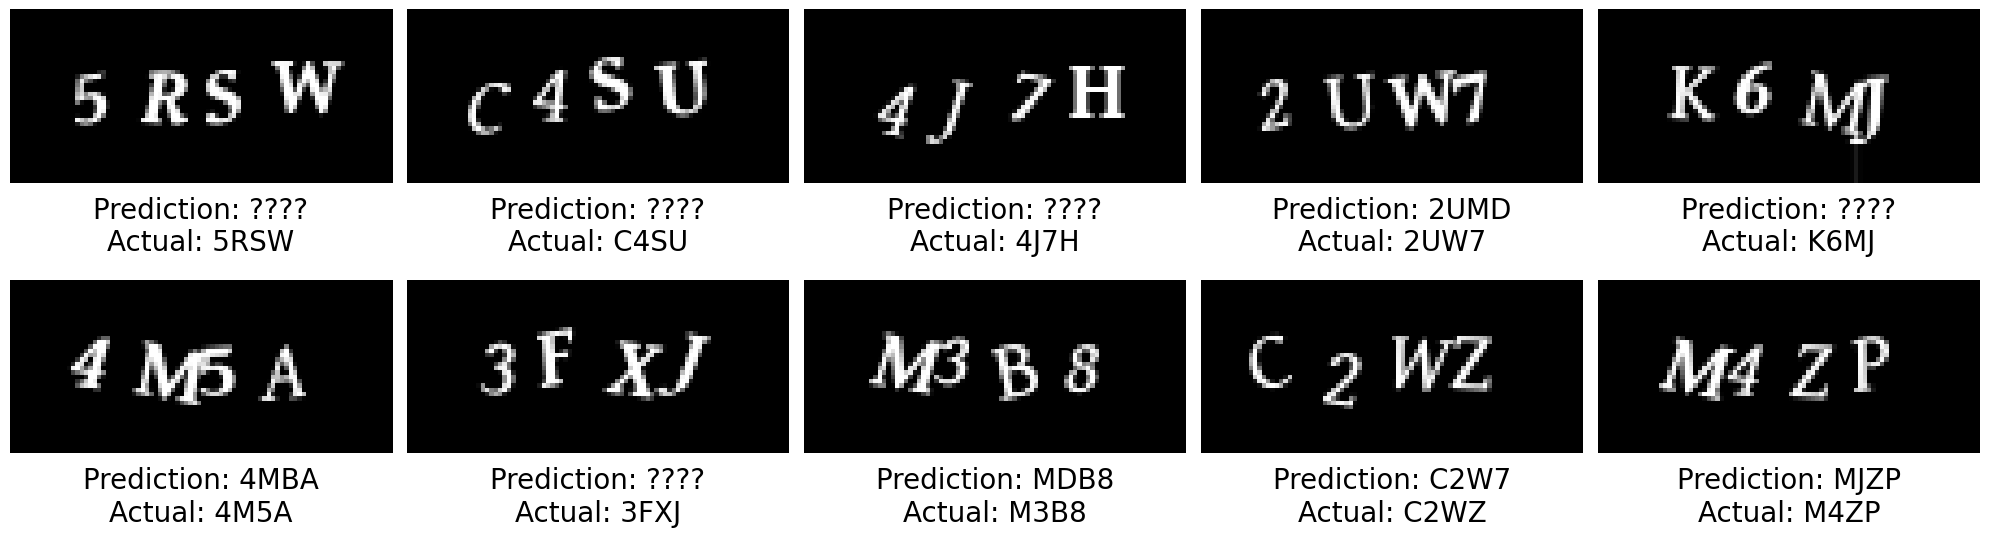

In [15]:
# Display a few correct and incorrect predictions
N_DISPLAY_SAMPLES = 10

correct_indices = []
incorrect_indices = []

for i, (pred, actual) in enumerate(zip(pred_texts, captcha_texts_test)):
    if pred == actual:
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

if correct_indices:
    print_images(
        [captcha_images_test[i] for i in correct_indices],
        texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
        n_rows=2
    )

if incorrect_indices:
    print_images(
        [captcha_images_test[i] for i in incorrect_indices],
        texts=[
            f"Prediction: {pred_texts[i]}\nActual: {captcha_texts_test[i]}"
            for i in incorrect_indices
        ],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )

## Open-ended extensions
Ideas:
- Improve character extraction robustness (morphological ops, better contour filtering)
- Train longer or with data augmentation
- Replace segmentation with a sequence model (CRNN)